In [1]:
import sys

sys.path.append("..")

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats.distributions import loguniform
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import QuantileTransformer
from sklearn.svm import SVR

In [3]:
src = Path("..") / "data" / "processed"
X = np.load(src / "train.npy", allow_pickle=True)
y = np.load(src / "train_target.npy", allow_pickle=True)
X.shape, y.shape

((1460, 68), (1460,))

In [4]:
transformer = QuantileTransformer(output_distribution="normal")
regr = TransformedTargetRegressor(SVR(kernel="rbf"), transformer=transformer)
c_values = np.logspace(-1, 3, 5)
gamma_values = np.logspace(-3, -1, 3)
gs = GridSearchCV(
    regr,
    param_grid={
        "regressor__C": c_values,
        "regressor__gamma": gamma_values,
    },
    cv=KFold(10, shuffle=True, random_state=46427),
    scoring="r2",
    n_jobs=-1,
)

In [5]:
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=46427, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=SVR(),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'regressor__gamma': array([0.001, 0.01 , 0.1  ])},
             scoring='r2')

In [6]:
r = gs.cv_results_
assert np.allclose(
    r["param_regressor__C"].data.astype(float), c_values.repeat(len(gamma_values))
)
shape = (len(c_values), len(gamma_values))
scores = r["mean_test_score"].reshape(shape)
std = r["std_test_score"].reshape(shape)

Text(50.722222222222214, 0.5, 'C')

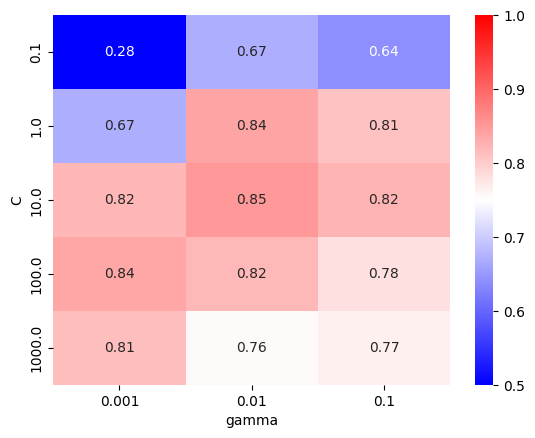

In [7]:
plt.close("all")
fig = plt.figure()
ax = fig.gca()
sns.heatmap(scores, cmap=plt.cm.bwr, vmin=0.5, vmax=1.0, annot=True, ax=ax)
ax.set_xticks(np.arange(len(gamma_values)) + 0.5)
ax.set_xticklabels(gamma_values)
ax.set_xlabel("gamma")
ax.set_yticks(np.arange(len(c_values)) + 0.5)
ax.set_yticklabels(c_values)
ax.set_ylabel("C")

Text(50.722222222222214, 0.5, 'C')

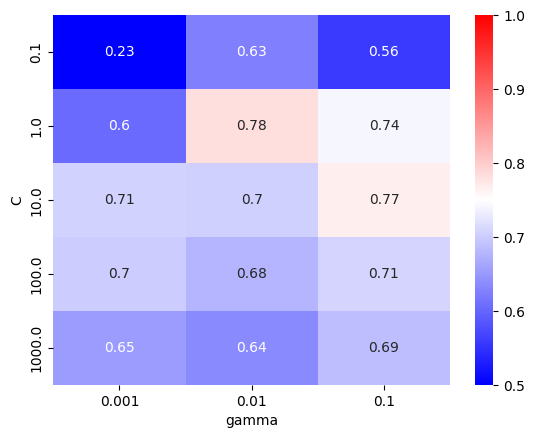

In [8]:
plt.close("all")
fig = plt.figure()
ax = fig.gca()
sns.heatmap(scores - std, cmap=plt.cm.bwr, vmin=0.5, vmax=1.0, annot=True, ax=ax)
ax.set_xticks(np.arange(len(gamma_values)) + 0.5)
ax.set_xticklabels(gamma_values)
ax.set_xlabel("gamma")
ax.set_yticks(np.arange(len(c_values)) + 0.5)
ax.set_yticklabels(c_values)
ax.set_ylabel("C")

In [9]:
rs = RandomizedSearchCV(
    estimator=regr,
    param_distributions={
        "regressor__C": loguniform(a=0.3, b=300.),
        "regressor__gamma": loguniform(0.001, 0.1),
    },
    cv=KFold(10, shuffle=True, random_state=41479),
    scoring="r2",
    n_jobs=-1,
    n_iter=100,
    random_state=56142,
)
rs.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=41479, shuffle=True),
                   estimator=TransformedTargetRegressor(regressor=SVR(),
                                                        transformer=QuantileTransformer(output_distribution='normal')),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'regressor__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ff408c893c0>,
                                        'regressor__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ff408c8bfd0>},
                   random_state=56142, scoring='r2')

In [10]:
print(f"Best model R2 = {rs.best_score_:.3f}")

Best model R2 = 0.863


In [11]:
rs.best_params_

{'regressor__C': 5.326541651126901, 'regressor__gamma': 0.04094867354606938}